# Exploratory Data Analysis - Patient, consommant et hospitalisation

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
patient=pd.read_csv("patient_anonyme.csv")
hospit_non_chr=pd.read_csv("base_hospit_non_chr_anonyme.csv")

/tmp/ipykernel_273/1855722776.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  hospit_non_chr=pd.read_csv("base_hospit_non_chr_anonyme.csv")


## Description de la population (base patient)

In [3]:
patient.head()

,date_h0,ALD_before,y_nais,BEN_RES_DPT,BEN_SEX_COD,dte_deces,CODE_PATIENT,Mort,Nb_survie
0,2011-11-22,0,1949,11,1,NaN,P0,False,2596
1,2013-12-05,0,1929,14,2,2015-03,P6,True,456
2,2015-07-02,0,1967,54,2,2015-08,P8,True,41
3,2011-05-19,0,1959,974,1,NaN,P13,False,2783
4,2010-03-18,0,1947,76,1,NaN,P16,False,3210


In [62]:
patient.describe()

,ALD_before,y_nais,BEN_SEX_COD,Nb_survie
count,10052.0,10052.000000,10052.000000,10052.000000
mean,0.0,1934.601870,1.512037,1130.750398
std,0.0,13.537071,0.499880,951.323657
min,0.0,1907.000000,1.000000,0.000000
25%,0.0,1925.000000,1.000000,171.000000
50%,0.0,1931.000000,2.000000,1101.000000
75%,0.0,1942.000000,2.000000,1836.000000
max,0.0,1997.000000,2.000000,3384.000000


### Âges, sexes, et décès des patients

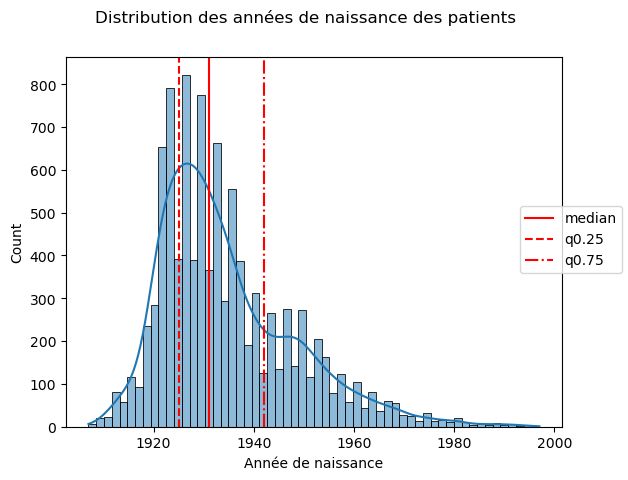

In [118]:
fig, ax = f, ax = plt.subplots()
sns.histplot(data=patient, x="y_nais", kde=True, ax=ax)
ax.axvline(x=patient.y_nais.median(), color='r', label='median')
ax.axvline(x=patient.y_nais.quantile(.25), color='r', linestyle='--', label='q0.25')
ax.axvline(x=patient.y_nais.quantile(.75), color='r', linestyle='-.', label='q0.75')
ax.set_xlabel("Année de naissance")
fig.suptitle("Distribution des années de naissance des patients")
fig.legend(loc=5)

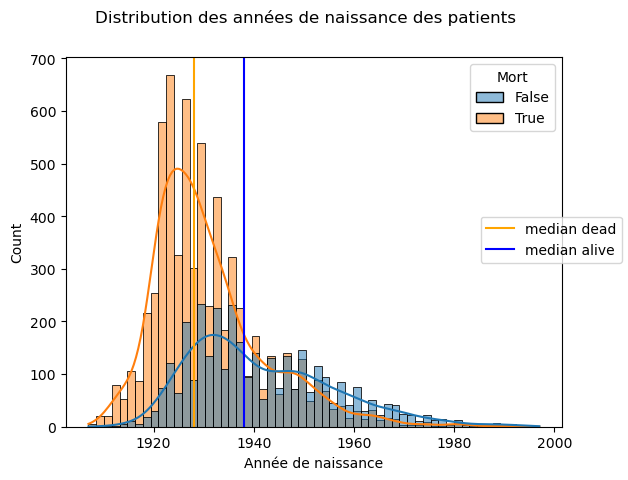

In [122]:
fig, ax = f, ax = plt.subplots()
sns.histplot(patient, x="y_nais", hue="Mort",
            kde=True,
            ax=ax,
            #stat="probability"
           )
ax.axvline(x=patient[patient["Mort"]==True].y_nais.median(), color='orange', label='median dead')
ax.axvline(x=patient[patient["Mort"]==False].y_nais.median(), color='blue', label='median alive')
ax.set_xlabel("Année de naissance")
fig.suptitle("Distribution des années de naissance des patients")
fig.legend(loc=5)

In [125]:
patient[patient['Mort']==False].describe()

,ALD_before,y_nais,BEN_SEX_COD,Nb_survie
count,3433.0,3433.000000,3433.000000,3433.000000
mean,0.0,1941.572094,1.489077,2033.184678
std,0.0,14.469971,0.499953,624.998717
min,0.0,1908.000000,1.000000,1096.000000
25%,0.0,1931.000000,1.000000,1468.000000
50%,0.0,1938.000000,1.000000,1951.000000
75%,0.0,1951.000000,2.000000,2545.000000
max,0.0,1997.000000,2.000000,3286.000000


+ L'année de naissance *moyenne* des patients qui ne sont pas décédés est : **1941**
+ L'année de naissance *médiane* des patients qui ne sont pas décédés est : **1938**

In [109]:
patient[patient['Mort']==True].describe()

,ALD_before,y_nais,BEN_SEX_COD,Nb_survie
count,6619.0,6619.000000,6619.000000,6619.000000
mean,0.0,1930.986705,1.523946,662.695271
std,0.0,11.465459,0.499464,728.250595
min,0.0,1907.000000,1.000000,0.000000
25%,0.0,1923.000000,1.000000,48.500000
50%,0.0,1928.000000,2.000000,388.000000
75%,0.0,1936.000000,2.000000,1082.000000
max,0.0,1994.000000,2.000000,3384.000000


+ L'année de naissance *moyenne* des patients décédés est : **1930**
+ L'année de naissance *médiane* des patients décédés est : **1928**

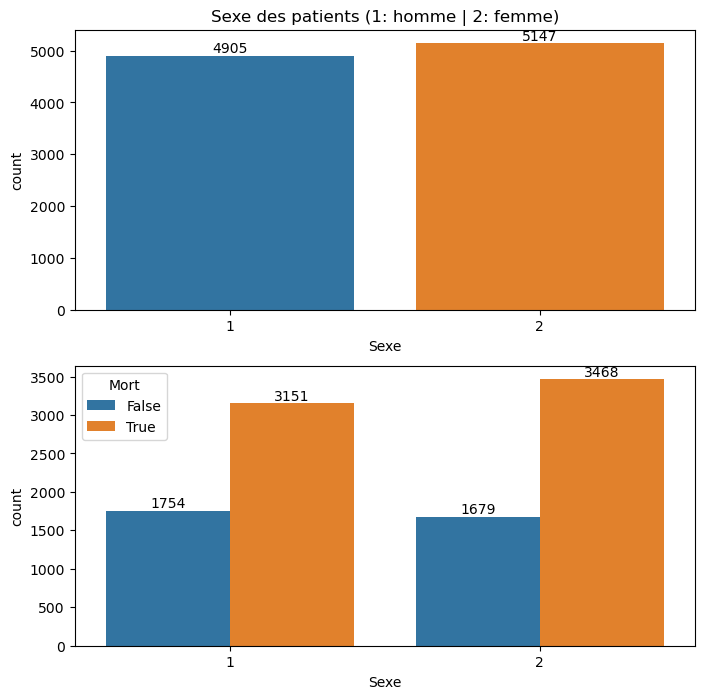

In [59]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(8, 8)

sns.countplot(x="BEN_SEX_COD", data=patient, ax=ax1)
ax1.set_title("Sexe des patients (1: homme | 2: femme)")
ax1.bar_label(ax1.containers[0])
ax1.set_xlabel("Sexe")

sns.countplot(x="BEN_SEX_COD", hue="Mort", data=patient, ax=ax2)
ax2.set_xlabel("Sexe")
ax2.bar_label(ax2.containers[0])
ax2.bar_label(ax2.containers[1])

plt.show()

Le dataset est plutôt équilibré avec :
+ 5147 femmes (**51.2%** de la population totale)
+ 4905 hommes (**48.8%** de la population totale)

Concernant les patients décédés (6619, **66%** de la population totale) :
+ 3468 femmes (**52.4%** de la population décédée)
+ 3151 hommes (**47.6%** de la population décédée)

Concernant les patients en vie à la fin de l'étude (3433, **34%** de la population totale) :
+ 1679 femmes (**52.4%** de la population décédée)
+ 1754 hommes (**47.6%** de la population décédée)

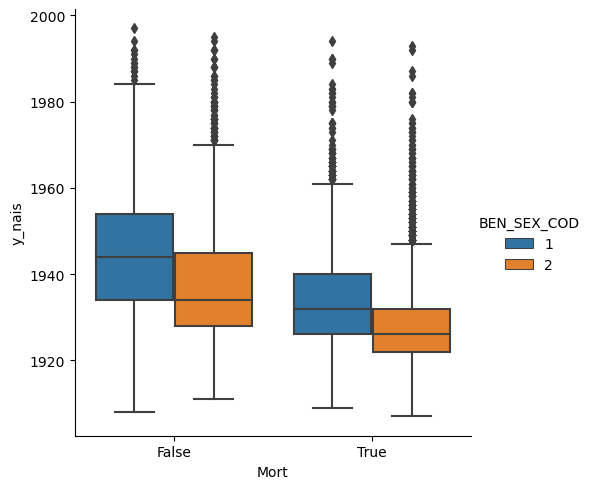

In [13]:
sns.catplot(data=patient, x="Mort", y="y_nais", hue="BEN_SEX_COD", kind="box")

### Etude de la variable Nb_survie

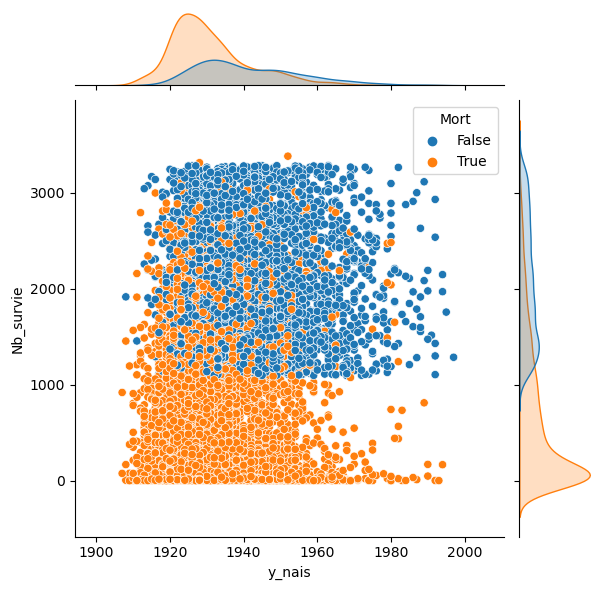

In [8]:
sns.jointplot(data=patient, x="y_nais", y="Nb_survie", hue="Mort")

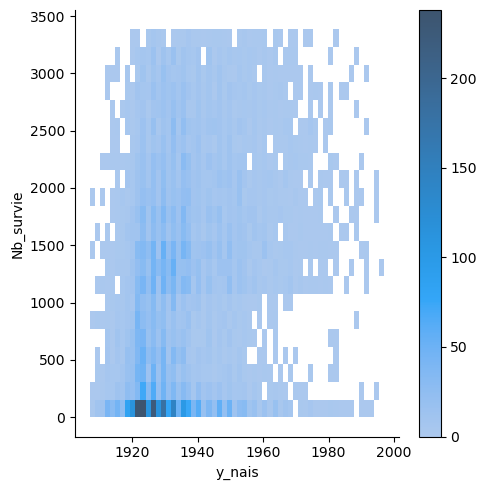

In [7]:
sns.displot(patient, x="y_nais", y="Nb_survie", cbar=True
            #kind="kde"
           )

## Corrélations

/tmp/ipykernel_273/2861342418.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(patient.drop("ALD_before", axis=1).corr())


<AxesSubplot: >

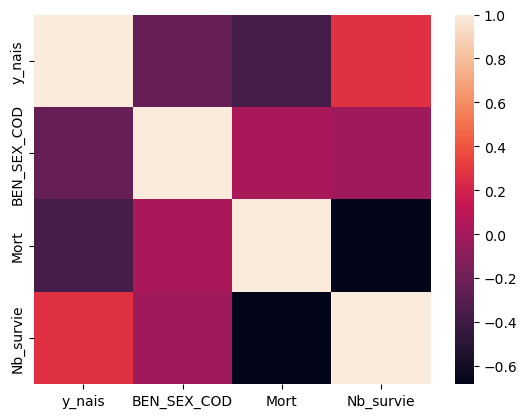

In [16]:
sns.heatmap(patient.drop("ALD_before", axis=1).corr())

## Pairplot

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


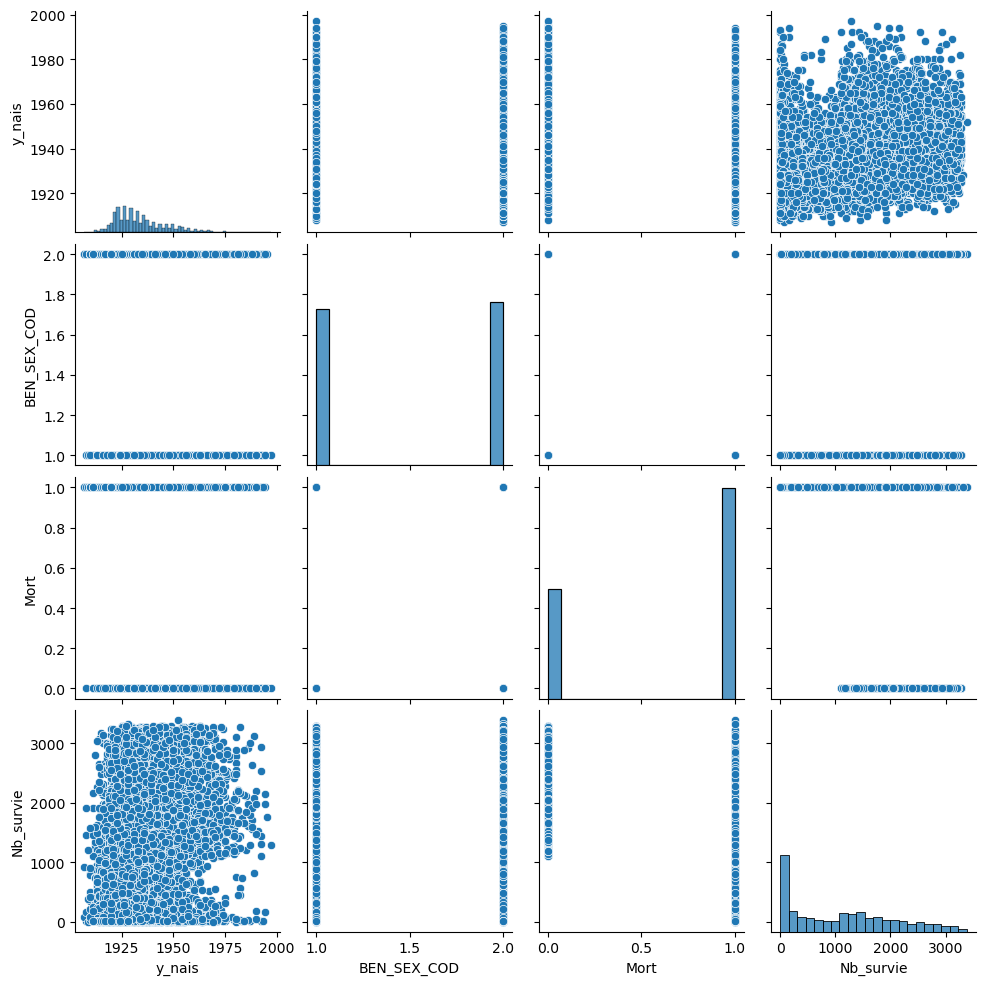

In [17]:
sns.pairplot(patient.drop("ALD_before", axis=1))